In [1]:
import numpy as np
import sys
import json 
with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])
import pandas as pd

from sklearn.model_selection import train_test_split as tts

from matplotlib import pyplot as plt
import seaborn as sns

from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.metrics import sepind

In [67]:
np.random.seed(0)
l1, l2 = np.random.normal(size=[1, 250], loc=20, scale=5), np.random.normal(size=[1, 250], loc=30, scale=5)

X, D = [], []
for ss in [5000, 1000, 500, 100, 50, 10]:
    x, d = [], []
    for rep in range(50):
        p1 = np.random.poisson(size=[ss, 250], lam=l1)
        p2 = np.random.poisson(size=[ss, 250], lam=l2)

        p = np.concatenate((p1, p2), axis=0)[:, :, np.newaxis]
        l = np.concatenate([np.ones((ss, 1)), np.zeros((ss, 1))], axis=0)

        m, s = sepind(p, l)

        trainIndex, testIndex = tts(np.arange(len(l)), test_size=.3, random_state=rep, shuffle=True, stratify=l)
        XTrain, XTest = p[trainIndex], p[testIndex]
        yTrain, yTest = l[trainIndex].ravel(), l[testIndex].ravel()
        out = DCE(random_state=rep).fit(X_train=XTrain[:, :, 0], y_train=yTrain).score(XTest[:, :, 0], yTest)

        x.append(m)
        d.append(out[2])
    X.append(x)
    D.append(d)
X = np.array(X).squeeze()
D = np.array(D)

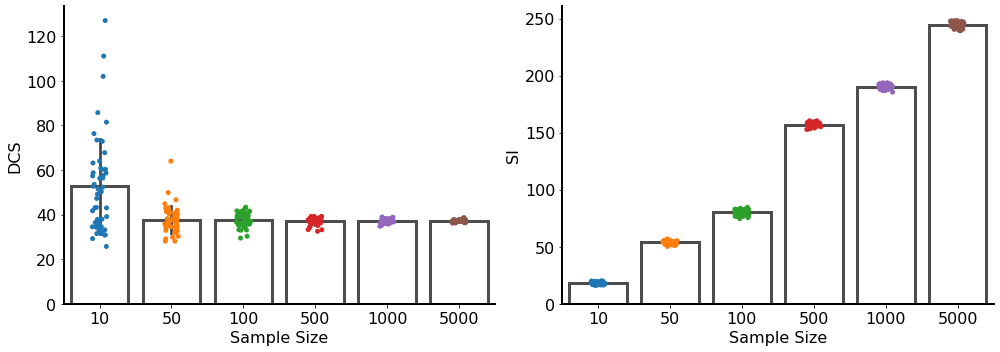

In [69]:
y = np.array([5000, 1000, 500, 100, 50, 10]).reshape(-1, 1) * np.ones((1, 50))
df1 = pd.DataFrame({'dcs':D.ravel(), 'ss':y.ravel().astype(np.uint16)})
df2 = pd.DataFrame({'si':X.ravel(), 'ss':y.ravel().astype(np.uint16)})

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df1, y='dcs', x='ss', ax=axs[0], ci='sd', lw=3, edgecolor='.3', facecolor=(0, 0, 0, 0))
sns.stripplot(data=df1, y='dcs', x='ss', ax=axs[0])
sns.barplot(data=df2, y='si', x='ss', ax=axs[1], ci='sd', lw=3, edgecolor='.3', facecolor=(0, 0, 0, 0))
sns.stripplot(data=df2, y='si', x='ss', ax=axs[1])

for ax in axs:
    ax.set_xlabel('Sample Size', fontsize=16)
    ax.set_ylabel(ax.get_ylabel().upper(), fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax.spines.values(), linewidth=2)
sns.despine()
fig.tight_layout()

In [73]:
np.random.seed(0)

ss = 50
X, D = [], []
for delta in ([0, .5, 1, 5, 10, 15, 25, 100]):
    l1, l2 = np.random.normal(size=[1, 250], loc=20, scale=5), np.random.normal(size=[1, 250], loc=20 + delta, scale=5)
    x, d = [], []
    for rep in range(50):
        p1 = np.random.poisson(size=[ss, 250], lam=l1)
        p2 = np.random.poisson(size=[ss, 250], lam=l2)

        p = np.concatenate((p1, p2), axis=0)[:, :, np.newaxis]
        l = np.concatenate([np.ones((ss, 1)), np.zeros((ss, 1))], axis=0)

        m, s = sepind(p, l)

        trainIndex, testIndex = tts(np.arange(len(l)), test_size=.3, random_state=rep, shuffle=True, stratify=l)
        XTrain, XTest = p[trainIndex], p[testIndex]
        yTrain, yTest = l[trainIndex].ravel(), l[testIndex].ravel()
        out = DCE(random_state=rep).fit(X_train=XTrain[:, :, 0], y_train=yTrain).score(XTest[:, :, 0], yTest)

        x.append(m)
        d.append(out[2])
    X.append(x)
    D.append(d)
X = np.array(X).squeeze()
D = np.array(D)

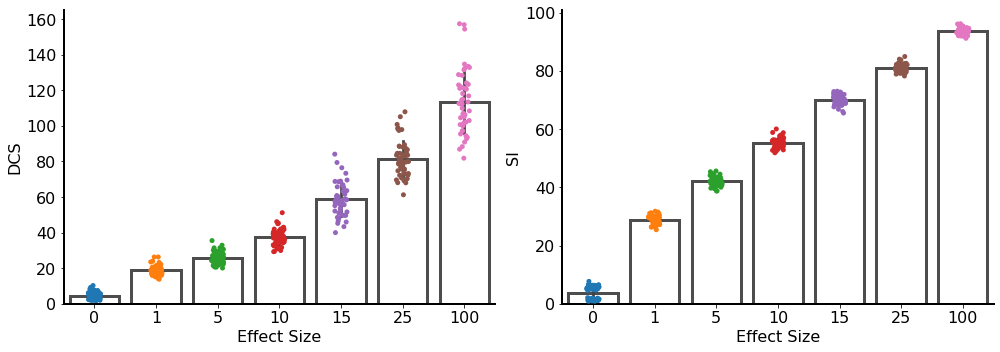

In [94]:
y = np.array([0, .5, 1, 5, 10, 15, 25, 100]).reshape(-1, 1) * np.ones((1, 50))
df1 = pd.DataFrame({'dcs':D.ravel(), 'ss':y.ravel().astype(np.uint16)})
df2 = pd.DataFrame({'si':X.ravel(), 'ss':y.ravel().astype(np.uint16)})

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df1, y='dcs', x='ss', ax=axs[0], ci='sd', lw=3, edgecolor='.3', facecolor=(0, 0, 0, 0))
sns.stripplot(data=df1, y='dcs', x='ss', ax=axs[0])
sns.barplot(data=df2, y='si', x='ss', ax=axs[1], ci='sd', lw=3, edgecolor='.3', facecolor=(0, 0, 0, 0))
sns.stripplot(data=df2, y='si', x='ss', ax=axs[1])

for ax in axs:
    ax.set_xlabel('Effect Size', fontsize=16)
    ax.set_ylabel(ax.get_ylabel().upper(), fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax.spines.values(), linewidth=2)
sns.despine()
fig.tight_layout()

In [140]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

class DescriminationConfidenceEstimator:
    def __init__(self, random_state=0):
        self.mdl = []
        self.random_state = random_state

    def fit(self, X_train, y_train):
        self.mdl = make_pipeline(StandardScaler(), SVC(C=2.4, probability=True, kernel='linear', 
            random_state=self.random_state)).fit(X_train, y_train)
        return self

    def score(self, X_test, y_test):
        y_pred = self.mdl.predict(X_test)
        dist = self.mdl['svc'].decision_function(X_test) / np.linalg.norm(self.mdl['svc'].coef_)
        d0, d1 = dist[y_test==0], dist[y_test==1]
        
        cfn = confusion_matrix(y_test, y_pred, labels=[0, 1], sample_weight=None, normalize=None)
        dth = np.abs(d0.mean() - d1.mean())
        dpr = np.sqrt(2) * np.abs(d0.mean() - d1.mean()) / np.sqrt(d0.var() + d1.var())
        return cfn, dth, dpr, d0.var(), d1.var(), d0.mean(), d1.mean()

In [158]:
np.random.seed(0)

ss = 50
delta = 10
X, D, M1, M2, S1, S2 = [], [], [], [], [], []

for nunit in ([5, 10, 50, 100, 250, 500, 1000]):
    l1, l2 = np.random.normal(size=[1, nunit], loc=20, scale=5), np.random.normal(size=[1, nunit], loc=20 + delta, scale=5)
    x, d, m1, m2, s1, s2 = [], [], [], [], [], []
    for rep in range(50):
        p1 = np.random.poisson(size=[ss, nunit], lam=l1)
        p2 = np.random.poisson(size=[ss, nunit], lam=l2)

        p = np.concatenate((p1, p2), axis=0)[:, :, np.newaxis]
        l = np.concatenate([np.ones((ss, 1)), np.zeros((ss, 1))], axis=0)

        trainIndex, testIndex = tts(np.arange(len(l)), test_size=.3, random_state=rep, shuffle=True, stratify=l)
        XTrain, XTest = p[trainIndex], p[testIndex]
        yTrain, yTest = l[trainIndex].ravel(), l[testIndex].ravel()
        out = DescriminationConfidenceEstimator(random_state=rep).fit(X_train=XTrain[:, :, 0], y_train=yTrain).score(XTest[:, :, 0], yTest)

        x.append(m)
        d.append(out[2])
        m1.append(out[5])
        m2.append(out[6])
        s1.append(out[3])
        s2.append(out[4])
        
    X.append(x)
    M1.append(m1)
    M2.append(m2)
    S1.append(s1)
    S2.append(s2)

X = np.array(X).squeeze()
D = np.array(D)
M1 = np.array(M1)
M2 = np.array(M2)
S1 = np.array(S1)
S2 = np.array(S2)

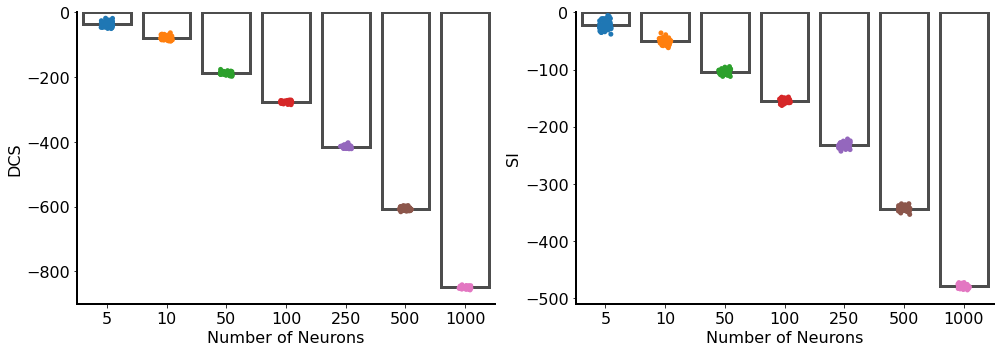

In [163]:
y = np.array([5, 10, 50, 100, 250, 500, 1000]).reshape(-1, 1) * np.ones((1, 50))
df1 = pd.DataFrame({'dcs':M1.ravel(), 'ss':y.ravel().astype(np.uint16)})
df2 = pd.DataFrame({'si':M2.ravel(), 'ss':y.ravel().astype(np.uint16)})
# df1 = pd.DataFrame({'dcs':(S1.T / np.sqrt(np.array([5, 10, 50, 100, 250, 500, 1000]))).T.ravel(), 'ss':y.ravel().astype(np.uint16)})
# df2 = pd.DataFrame({'si':(S2.T / np.sqrt(np.array([5, 10, 50, 100, 250, 500, 1000]))).T.ravel(), 'ss':y.ravel().astype(np.uint16)})

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df1, y='dcs', x='ss', ax=axs[0], ci='sd', lw=3, edgecolor='.3', facecolor=(0, 0, 0, 0))
sns.stripplot(data=df1, y='dcs', x='ss', ax=axs[0])
sns.barplot(data=df2, y='si', x='ss', ax=axs[1], ci='sd', lw=3, edgecolor='.3', facecolor=(0, 0, 0, 0))
sns.stripplot(data=df2, y='si', x='ss', ax=axs[1])

for ax in axs:
    ax.set_xlabel('Number of Neurons', fontsize=16)
    ax.set_ylabel(ax.get_ylabel().upper(), fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax.spines.values(), linewidth=2)
sns.despine()
fig.tight_layout()

In [126]:
np.random.seed(0)

ss = 50
delta = 10
X, D = [], []

for nunit in ([5, 10, 50, 100, 250, 500, 1000]):
    l1, l2 = np.random.normal(size=[1, nunit], loc=20, scale=5), np.random.normal(size=[1, nunit], loc=20 + delta, scale=5)
    x, d = [], []
    for rep in range(50):
        p1 = np.random.poisson(size=[ss, nunit], lam=l1)
        p2 = np.random.poisson(size=[ss, nunit], lam=l2)

        p = np.concatenate((p1, p2), axis=0)[:, :, np.newaxis]
        l = np.concatenate([np.ones((ss, 1)), np.zeros((ss, 1))], axis=0)

        m, s = sepind(p, l)

        trainIndex, testIndex = tts(np.arange(len(l)), test_size=.3, random_state=rep, shuffle=True, stratify=l)
        XTrain, XTest = p[trainIndex], p[testIndex]
        yTrain, yTest = l[trainIndex].ravel(), l[testIndex].ravel()
        out = DescriminationConfidenceEstimator(random_state=rep).fit(X_train=XTrain[:, :, 0], y_train=yTrain).score(XTest[:, :, 0], yTest)

        x.append(m)
        d.append(out[2])
    X.append(x)
    D.append(d)
X = np.array(X).squeeze()
D = np.array(D)

15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 15
15 1

KeyboardInterrupt: 

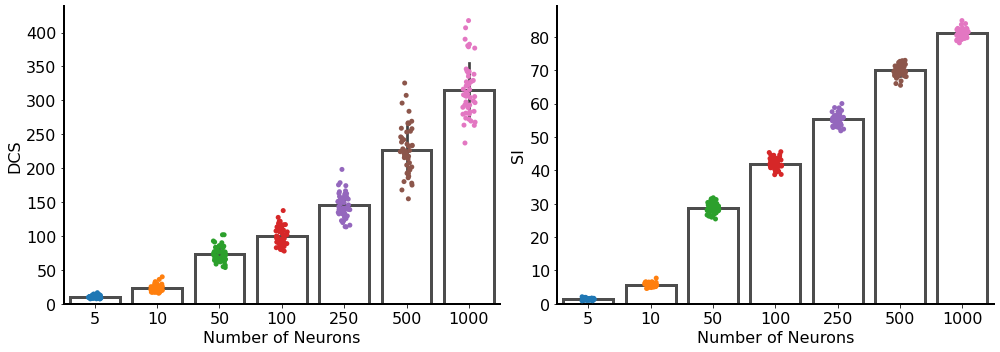

In [124]:
y = np.array([5, 10, 50, 100, 250, 500, 1000]).reshape(-1, 1) * np.ones((1, 50))
df1 = pd.DataFrame({'dcs':D.ravel(), 'ss':y.ravel().astype(np.uint16)})
df2 = pd.DataFrame({'si':X.ravel(), 'ss':y.ravel().astype(np.uint16)})
# df1 = pd.DataFrame({'dcs':(D.T / np.sqrt(np.array([5, 10, 50, 100, 250, 500, 1000]))).T.ravel(), 'ss':y.ravel().astype(np.uint16)})
# df2 = pd.DataFrame({'si':(X.T / np.sqrt(np.array([5, 10, 50, 100, 250, 500, 1000]))).T.ravel(), 'ss':y.ravel().astype(np.uint16)})

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df1, y='dcs', x='ss', ax=axs[0], ci='sd', lw=3, edgecolor='.3', facecolor=(0, 0, 0, 0))
sns.stripplot(data=df1, y='dcs', x='ss', ax=axs[0])
sns.barplot(data=df2, y='si', x='ss', ax=axs[1], ci='sd', lw=3, edgecolor='.3', facecolor=(0, 0, 0, 0))
sns.stripplot(data=df2, y='si', x='ss', ax=axs[1])

for ax in axs:
    ax.set_xlabel('Number of Neurons', fontsize=16)
    ax.set_ylabel(ax.get_ylabel().upper(), fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax.spines.values(), linewidth=2)
sns.despine()
fig.tight_layout()

In [85]:
(D.T / np.array([10, 50, 100, 250, 1000])).T.ravel()

(5, 50)

In [86]:
y.shape

(5, 50)